# CLUSTERING TEAM ANALYSIS

## 1. Classes

In [1]:
import pyspark
from pyspark.sql import functions as F
from pyspark.sql.types import StringType
from pyspark.sql import SparkSession
from pyspark.sql import DataFrame
from functools import reduce

from pyspark.ml.clustering import KMeans

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

import configparser
config = configparser.ConfigParser()
config.read('mainconfig_secret.ini')

# Obtener las credenciales
db_host = config['MySQL']['host']
db_user = config['MySQL']['user']
db_password = config['MySQL']['password']
db_name = config['MySQL']['database']
db_table = config['MySQL']['table']
db_port = config['MySQL']['port']

print(pyspark.__file__)

/Users/rodrigobenitogarcia/anaconda3/envs/ml_env/lib/python3.11/site-packages/pyspark/__init__.py


### 1.1. PySpark

In [2]:
class mySpark():
    def __init__(self):
        self.config_path = "/Users/rodrigobenitogarcia/jars/mysql-connector-j-9.5.0/mysql-connector-j-9.5.0.jar"
        self.appName = "DBConection"
        self.mysql_user = db_user
        self.mysql_pwd = db_password
        self.mysql_db = db_name
        self.mysql_table = db_table
        self.mysql_url = f"jdbc:mysql://{db_host}:{db_port}/{self.mysql_db}?serverTimezone=UTC&useSSL=false"
        self.mysql_driver = "com.mysql.cj.jdbc.Driver"
    

    def create_session(self):
        return SparkSession.builder \
            .appName(self.appName) \
            .config("spark.jars", self.config_path) \
            .config("spark.driver.extraClassPath", self.config_path) \
            .config("spark.executor.extraClassPath", self.config_path) \
            .config("spark.driver.memory", "8g") \
            .config("spark.executor.memory", "8g") \
            .config("spark.driver.maxResultSize", "4g") \
            .config("spark.sql.shuffle.partitions", "200") \
            .getOrCreate()
    
    @staticmethod
    def end_session(my_spark_obj):
        return my_spark_obj.stop()
    
    def load_spark_data(self, my_spark_obj):
        return my_spark_obj.read.format("jdbc").options(
            url=self.mysql_url,
            driver=self.mysql_driver,
            dbtable=self.mysql_table,
            user=self.mysql_user,
            password=self.mysql_pwd
        ).load()

def rename_columns(df: DataFrame, rename_dict: dict) -> DataFrame:
    """
    Rename multiple columns of a PySpark dataframe using a dictionary.
    
    Parameters
    ----------
    df : pyspark.sql.DataFrame
        input dataframe.
    rename_dict : dict
        Dict with the key: value.
        Ejemplo: {"old_col": "new_col", "old_col2": "new_col2"}
    
    Returns
    -------
    pyspark.sql.DataFrame
        Dataframe with columns renamed.
    """
    return reduce(
        lambda df_temp, kv: df_temp.withColumnRenamed(kv[0], kv[1]),
        rename_dict.items(),
        df
    )

Load the object in order to create the spark session, **remember** to open your sql connection before loading it.

In [3]:
spark_obj = mySpark()
spark_t = spark_obj.create_session()

df = spark_obj.load_spark_data(my_spark_obj=spark_t)

# The following cells will show the basic information related to the dataset previously loaded.
print(f"Número de filas: {df.count()}")
print(f"Número de columnas: {len(df.columns)}")

# Show the Schema
print(df.printSchema())

26/02/16 19:52:16 WARN Utils: Your hostname, MacBook-Pro-de-Rodrigo.local resolves to a loopback address: 127.0.0.1; using 192.168.1.137 instead (on interface en0)
26/02/16 19:52:16 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
26/02/16 19:52:17 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/02/16 19:52:18 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


Número de filas: 189988
Número de columnas: 13
root
 |-- name: string (nullable = true)
 |-- homeValue: double (nullable = true)
 |-- awayValue: double (nullable = true)
 |-- homeTotal: integer (nullable = true)
 |-- awayTotal: integer (nullable = true)
 |-- period: string (nullable = true)
 |-- LeagueId: integer (nullable = true)
 |-- Year: string (nullable = true)
 |-- SeasonId: integer (nullable = true)
 |-- MatchId: integer (nullable = true)
 |-- Round: string (nullable = true)
 |-- homeTeam: string (nullable = true)
 |-- awayTeam: string (nullable = true)

None


Once the data schema is visualized, we can obtain general statistics like count, mean, stddev, min, max.

In addition, like some of the columns are categorical, we only will show the numeric values.

In [4]:
df.select("homeValue", "awayValue", "homeTotal", "awayTotal").describe().show(truncate=False)

26/02/16 19:52:23 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+-----------------+-----------------+------------------+------------------+
|summary|homeValue        |awayValue        |homeTotal         |awayTotal         |
+-------+-----------------+-----------------+------------------+------------------+
|count  |189988           |189988           |30475             |30475             |
|mean   |18.18079389224575|17.26238293997513|17.726037735849058|17.510943396226416|
|stddev |48.32237718635825|45.44318214881185|12.546666435798686|12.832449347790691|
|min    |0.0              |0.0              |0                 |0                 |
|max    |513.0            |501.0            |65                |64                |
+-------+-----------------+-----------------+------------------+------------------+



### 1.2. Pandas

### 1.3. General functions

In [5]:
def trim_all_strings(df):
    return df.select([
        F.trim(F.col(c)).alias(c) if isinstance(df.schema[c].dataType, StringType) 
        else F.col(c) 
        for c in df.columns
    ])

In [6]:
[row['name'] for row in df.select('name').distinct().collect()]

['Accurate passes                                   ',
 'Duels                                             ',
 'Blocked shots                                     ',
 'Tackles                                           ',
 'Total saves                                       ',
 'Total tackles                                     ',
 'Fouls                                             ',
 'Crosses                                           ',
 'Offsides                                          ',
 'Shots inside box                                  ',
 'Throw-ins                                         ',
 'Dispossessed                                      ',
 'Fouled in final third                             ',
 'Shots on target                                   ',
 'Corner kicks                                      ',
 'Aerial duels                                      ',
 'Passes                                            ',
 'Yellow cards                                      ',
 'Long bal

## 2. Analysis

Now we are going to create a cluster related to the possession and goals scored and received.

In [7]:
df = trim_all_strings(df=df)
stats_measure = [
    # Ofensivas
    'Shots on target',  'Big chances', 'Final third entries', 'Accurate passes', # 'Expected goals',
    # Defensivas
    'Tackles won', 'Interceptions', 'Clearances', # 'Recoveries',
    # Control
    'Ball possession', 'Passes', 'Ground duels',
    # Resultado
    'Goals', 'Goalkeeper saves'
]

print(f"📊 Variables seleccionadas: {len(stats_measure)}")
print("\n".join([f"  - {feat}" for feat in stats_measure]))

my_columns = ['name', 'homeValue', 'awayValue', 'period', 'MatchId', 'Year', 'homeTeam', 'awayTeam']
df_filtered_to_cluster = df.filter(F.col('name').isin(stats_measure))
df_filtered_to_cluster = df_filtered_to_cluster.select(*my_columns)

# Ver cuántos datos tenemos
print(f"\n🔢 Registros totales: {df_filtered_to_cluster.count()}")
print(f"📅 Temporadas: {df_filtered_to_cluster.select('Year').distinct().count()}")

# Verificar que todas las variables están presentes
print("\n✅ Variables disponibles:")
df_filtered_to_cluster.groupBy('name').count().orderBy('name').show(20, truncate=False)

📊 Variables seleccionadas: 12
  - Shots on target
  - Big chances
  - Final third entries
  - Accurate passes
  - Tackles won
  - Interceptions
  - Clearances
  - Ball possession
  - Passes
  - Ground duels
  - Goals
  - Goalkeeper saves

🔢 Registros totales: 60820
📅 Temporadas: 8

✅ Variables disponibles:
+-------------------+-----+
|name               |count|
+-------------------+-----+
|Accurate passes    |5084 |
|Ball possession    |5084 |
|Big chances        |4926 |
|Clearances         |5084 |
|Final third entries|5080 |
|Goalkeeper saves   |5058 |
|Goals              |5084 |
|Ground duels       |5084 |
|Interceptions      |5084 |
|Passes             |5084 |
|Shots on target    |5084 |
|Tackles won        |5084 |
+-------------------+-----+



In [8]:
df_filtered_to_cluster = df_filtered_to_cluster.filter(F.col('Year') != "18/19")

Convert values to numerics, avoiding string.

In [9]:
df_filtered_to_cluster = df_filtered_to_cluster.withColumn('homeValue', F.col('homeValue').cast('double')).withColumn('awayValue', F.col('awayValue').cast('double'))

print("✅ Datos filtrados y preparados")
print(f"📊 Total registros: {df_filtered_to_cluster.count()}")
print(f"📅 Temporadas: {sorted([row.Year for row in df_filtered_to_cluster.select('Year').distinct().collect()])}")

# 4. Verificar que todas las variables están presentes
print("\n=== Distribución por variable ===")
df_filtered_to_cluster.groupBy('name').count().orderBy(F.desc('count')).show(15, truncate=False)


✅ Datos filtrados y preparados
📊 Total registros: 60008


📅 Temporadas: ['19/20', '20/21', '21/22', '22/23', '23/24', '24/25', '25/26']

=== Distribución por variable ===
+-------------------+-----+
|name               |count|
+-------------------+-----+
|Ball possession    |5016 |
|Tackles won        |5016 |
|Passes             |5016 |
|Shots on target    |5016 |
|Goals              |5016 |
|Interceptions      |5016 |
|Clearances         |5016 |
|Accurate passes    |5016 |
|Ground duels       |5016 |
|Final third entries|5012 |
|Goalkeeper saves   |4990 |
|Big chances        |4862 |
+-------------------+-----+



In [10]:
df_home = df_filtered_to_cluster.select(
    F.col('name').alias('stat'),
    F.col('homeValue').alias('value'),
    F.col('period'),
    F.col('Year').alias('year'),
    F.col('homeTeam').alias('team'),
    F.lit('home').alias('location')
)

df_away = df_filtered_to_cluster.select(
    F.col('name').alias('stat'),
    F.col('awayValue').alias('value'),
    F.col('period'),
    F.col('Year').alias('year'),
    F.col('awayTeam').alias('team'),
    F.lit('away').alias('location')
)

df_combined = df_home.union(df_away)

print(f"✅ Datos home: {df_home.count()} registros")
print(f"✅ Datos away: {df_away.count()} registros")
print(f"✅ Datos combinados: {df_combined.count()} registros")

✅ Datos home: 60008 registros
✅ Datos away: 60008 registros
✅ Datos combinados: 120016 registros


In [11]:
df_pivot = df_combined.groupBy('team', 'year', 'period', 'location') \
    .pivot('stat') \
    .agg(F.avg('value'))  # avg por si hay duplicados (aunque no debería)

print("\n✅ Datos pivotados")
df_pivot.printSchema()
df_pivot.show(5, truncate=False)


✅ Datos pivotados
root
 |-- team: string (nullable = true)
 |-- year: string (nullable = true)
 |-- period: string (nullable = true)
 |-- location: string (nullable = false)
 |-- Accurate passes: double (nullable = true)
 |-- Ball possession: double (nullable = true)
 |-- Big chances: double (nullable = true)
 |-- Clearances: double (nullable = true)
 |-- Final third entries: double (nullable = true)
 |-- Goalkeeper saves: double (nullable = true)
 |-- Goals: double (nullable = true)
 |-- Ground duels: double (nullable = true)
 |-- Interceptions: double (nullable = true)
 |-- Passes: double (nullable = true)
 |-- Shots on target: double (nullable = true)
 |-- Tackles won: double (nullable = true)



+----------------+-----+------+--------+------------------+-----------------+------------------+------------------+-------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+
|team            |year |period|location|Accurate passes   |Ball possession  |Big chances       |Clearances        |Final third entries|Goalkeeper saves  |Goals              |Ground duels      |Interceptions     |Passes            |Shots on target   |Tackles won       |
+----------------+-----+------+--------+------------------+-----------------+------------------+------------------+-------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+
|osasuna         |20/21|2ND   |home    |134.31578947368422|46.21052631578947|0.7777777777777778|8.578947368421053 |31.68421052631579  |1.0526315789473684|0.631578947368421  |15.3157894736842

In [12]:
df_aggregated_multi = df_pivot.groupBy('team', 'year', 'location').agg(
    F.avg('Ball possession').alias('ball_possession'),
    F.sum('Shots on target').alias('shots_on_target'),
    F.sum('Big chances').alias('big_chances'),
    F.sum('Final third entries').alias('final_third_entries'),
    F.sum('Accurate passes').alias('accurate_passes'),
    F.sum('Goals').alias('goals'),
    F.sum('Tackles won').alias('tackles_won'),
    F.sum('Interceptions').alias('interceptions'),
    F.sum('Clearances').alias('clearances'),
    F.sum('Goalkeeper saves').alias('goalkeeper_saves'),
    F.sum('Passes').alias('passes'),
    F.sum('Ground duels').alias('ground_duels')
)

print(f"📊 Registros: {df_aggregated_multi.count()} (2 por equipo-temporada: home y away)")

📊 Registros: 280 (2 por equipo-temporada: home y away)


In [13]:
# Convertir a Pandas para siguiente paso
df_pandas_multi = df_aggregated_multi.toPandas()

print(f"\n✅ Convertido a Pandas: {len(df_pandas_multi)} registros")
print(f"📊 Columnas: {df_pandas_multi.columns.tolist()}")

# Verificar valores nulos
print("\n🔍 Verificación de valores nulos:")
print(df_pandas_multi.isnull().sum())


✅ Convertido a Pandas: 280 registros
📊 Columnas: ['team', 'year', 'location', 'ball_possession', 'shots_on_target', 'big_chances', 'final_third_entries', 'accurate_passes', 'goals', 'tackles_won', 'interceptions', 'clearances', 'goalkeeper_saves', 'passes', 'ground_duels']

🔍 Verificación de valores nulos:
team                   0
year                   0
location               0
ball_possession        0
shots_on_target        0
big_chances            0
final_third_entries    0
accurate_passes        0
goals                  0
tackles_won            0
interceptions          0
clearances             0
goalkeeper_saves       0
passes                 0
ground_duels           0
dtype: int64


### 2.1. Correlation between variables

=== MATRIZ DE CORRELACIÓN ===
                     shots_on_target  big_chances  final_third_entries  \
shots_on_target                 1.00         0.86                 0.45   
big_chances                     0.86         1.00                 0.34   
final_third_entries             0.45         0.34                 1.00   
accurate_passes                 0.74         0.70                 0.24   
goals                           0.84         0.85                 0.29   
tackles_won                     0.01        -0.02                -0.04   
interceptions                  -0.29        -0.37                -0.14   
clearances                     -0.48        -0.37                -0.44   
goalkeeper_saves               -0.42        -0.36                -0.46   
ball_possession                 0.71         0.64                 0.38   
passes                          0.73         0.69                 0.28   
ground_duels                    0.35         0.23                -0.05   

       

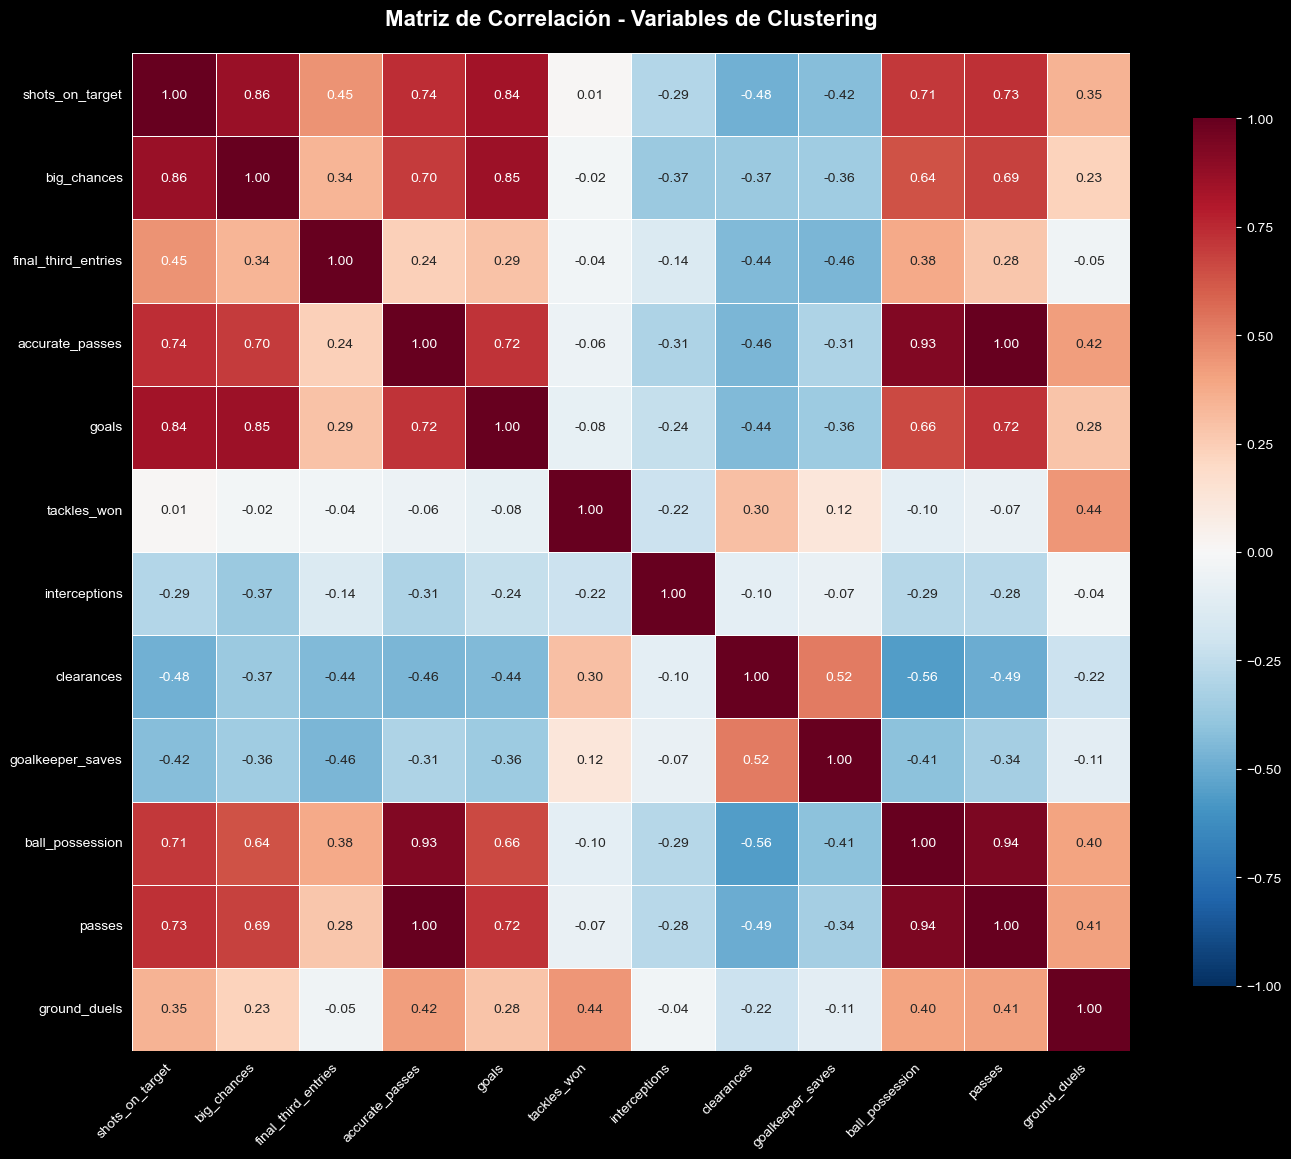


=== CORRELACIONES ALTAS (|r| > 0.80) ===
  shots_on_target <-> big_chances: 0.862
  shots_on_target <-> goals: 0.844
  big_chances <-> goals: 0.853
  accurate_passes <-> ball_possession: 0.930
  accurate_passes <-> passes: 0.996
  ball_possession <-> passes: 0.943


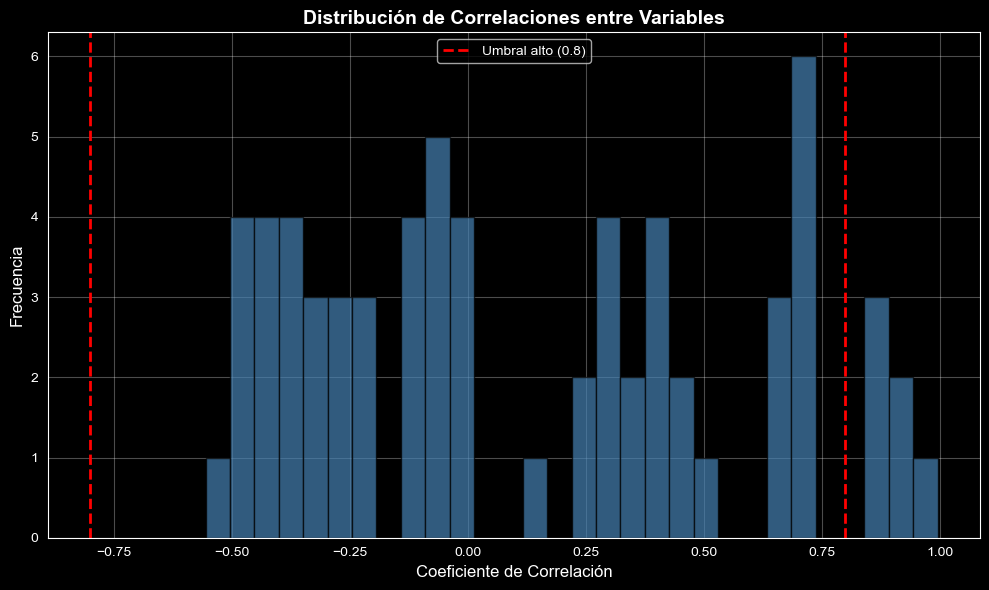


=== RESUMEN DE CORRELACIONES ===
Correlación promedio: 0.124
Correlación máxima: 0.996
Correlación mínima: -0.556
Desviación estándar: 0.453

=== CORRELACIÓN CON GOALS (variable objetivo) ===
goals                  1.000000
big_chances            0.852563
shots_on_target        0.843724
accurate_passes        0.722615
passes                 0.719274
ball_possession        0.659024
final_third_entries    0.289528
ground_duels           0.284356
tackles_won           -0.079872
interceptions         -0.237599
goalkeeper_saves      -0.360424
clearances            -0.439003
Name: goals, dtype: float64

🎯 TOP 5 variables más correlacionadas con Goals:
  big_chances: 0.853
  shots_on_target: 0.844
  accurate_passes: 0.723
  passes: 0.719
  ball_possession: 0.659


In [14]:
# Seleccionar solo las columnas numéricas (features)
feature_columns = [
    # Ofensivas (5)
    'shots_on_target',      # Volumen de ocasiones
    'big_chances',          # Calidad de ocasiones
    'final_third_entries',  # Penetración
    'accurate_passes',      # Construcción (SIN passes)
    'goals',                # Conversión final
    
    # Defensivas (4)
    'tackles_won',          # Presión defensiva
    'interceptions',        # Lectura del juego
    'clearances',           # Solidez
    'goalkeeper_saves',     # Presión recibida
    
    # Control (2)
    'ball_possession',      # Dominio
    'passes',
    
    # Intensidad (1)
    'ground_duels'          # Físico (baja correlación con otras)
]

# Crear matriz de correlación
correlation_matrix = df_pandas_multi[feature_columns].corr()

print("=== MATRIZ DE CORRELACIÓN ===")
print(correlation_matrix.round(2))

# Visualización 1: Heatmap de correlación
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, 
            annot=True,          # Mostrar valores
            fmt='.2f',           # 2 decimales
            cmap='RdBu_r',       # Colores: rojo (negativo) a azul (positivo)
            center=0,            # Centrar en 0
            square=True,         # Celdas cuadradas
            linewidths=0.5,
            cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1)

plt.title('Matriz de Correlación - Variables de Clustering', fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Identificar correlaciones altas (>0.8 o <-0.8)
print("\n=== CORRELACIONES ALTAS (|r| > 0.80) ===")
high_corr = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_value = correlation_matrix.iloc[i, j]
        if abs(corr_value) > 0.80:
            var1 = correlation_matrix.columns[i]
            var2 = correlation_matrix.columns[j]
            high_corr.append((var1, var2, corr_value))
            print(f"  {var1} <-> {var2}: {corr_value:.3f}")

if len(high_corr) == 0:
    print("  ✅ No hay correlaciones extremadamente altas")

# Visualización 2: Distribución de correlaciones
plt.figure(figsize=(10, 6))

# Obtener solo el triángulo superior (sin diagonal)
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
corr_values = correlation_matrix.mask(mask).values.flatten()
corr_values = corr_values[~np.isnan(corr_values)]

plt.hist(corr_values, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
plt.axvline(x=0.8, color='red', linestyle='--', linewidth=2, label='Umbral alto (0.8)')
plt.axvline(x=-0.8, color='red', linestyle='--', linewidth=2)
plt.xlabel('Coeficiente de Correlación', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.title('Distribución de Correlaciones entre Variables', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Resumen estadístico
print("\n=== RESUMEN DE CORRELACIONES ===")
print(f"Correlación promedio: {corr_values.mean():.3f}")
print(f"Correlación máxima: {corr_values.max():.3f}")
print(f"Correlación mínima: {corr_values.min():.3f}")
print(f"Desviación estándar: {corr_values.std():.3f}")

# Identificar las variables más y menos correlacionadas con Goals
print("\n=== CORRELACIÓN CON GOALS (variable objetivo) ===")
goals_corr = correlation_matrix['goals'].sort_values(ascending=False)
print(goals_corr)

# Top 5 más correlacionadas con Goals
print("\n🎯 TOP 5 variables más correlacionadas con Goals:")
for var, corr in goals_corr[1:6].items():  # [1:] para excluir goals consigo mismo
    print(f"  {var}: {corr:.3f}")

✅ Variables finales: 11
  - shots_on_target
  - big_chances
  - final_third_entries
  - accurate_passes
  - goals
  - tackles_won
  - interceptions
  - clearances
  - goalkeeper_saves
  - ball_possession
  - ground_duels

📊 Dataset final: 280 registros x 11 features

=== NUEVA MATRIZ DE CORRELACIÓN (sin variables redundantes) ===
  shots_on_target <-> big_chances: 0.862
  big_chances <-> goals: 0.853
  accurate_passes <-> ball_possession: 0.930

✅ Correlaciones |r| > 0.85: 3


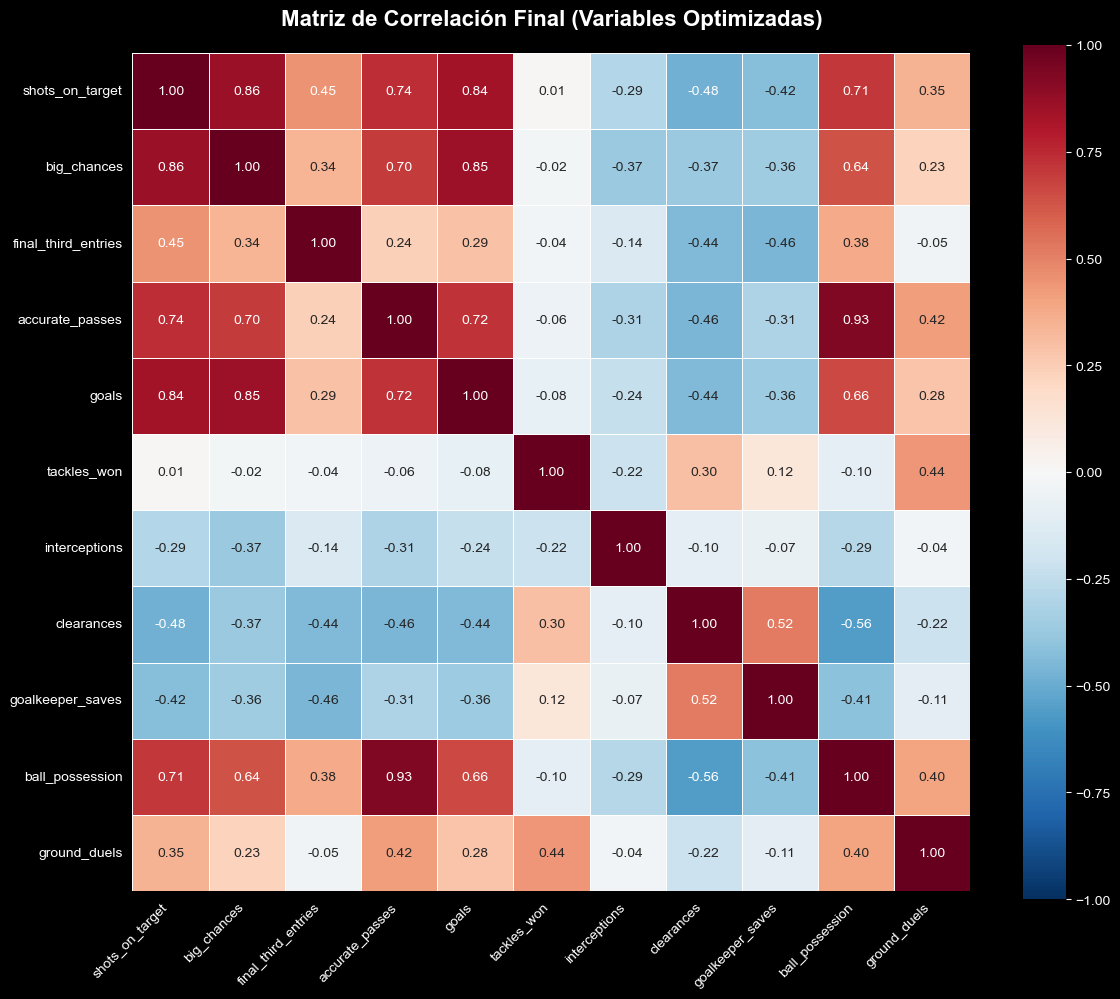


=== ESTADÍSTICAS DESCRIPTIVAS ===
       shots_on_target  big_chances  final_third_entries  accurate_passes  \
count           280.00       280.00               280.00           280.00   
mean              4.07         2.08                54.38           349.74   
std               1.13         0.74                 6.86            95.97   
min               2.26         0.74                39.95           169.37   
25%               3.32         1.57                49.76           276.63   
50%               3.84         1.89                53.50           340.18   
75%               4.59         2.48                58.29           395.34   
max               7.82         4.83                77.47           652.79   

        goals  tackles_won  interceptions  clearances  goalkeeper_saves  \
count  280.00       280.00         280.00      280.00            280.00   
mean     1.28         9.40           8.75       19.35              2.81   
std      0.48         1.21           1.43     

In [15]:
# Variables a ELIMINAR por redundancia
variables_a_eliminar = ['passes']  # Redundante con accurate_passes

# Variables FINALES para clustering
final_features = [
    # Ofensivas (5)
    'shots_on_target',      # Volumen de ocasiones
    'big_chances',          # Calidad de ocasiones
    'final_third_entries',  # Penetración
    'accurate_passes',      # Construcción (SIN passes)
    'goals',                # Conversión final
    
    # Defensivas (4)
    'tackles_won',          # Presión defensiva
    'interceptions',        # Lectura del juego
    'clearances',           # Solidez
    'goalkeeper_saves',     # Presión recibida
    
    # Control (1)
    'ball_possession',      # Dominio
    
    # Intensidad (1) - OPCIONAL: podríamos eliminar también
    'ground_duels'          # Físico (baja correlación con otras)
]

print(f"✅ Variables finales: {len(final_features)}")
print("\n".join([f"  - {feat}" for feat in final_features]))

# Crear dataset final
df_final_features = df_pandas_multi[['team', 'year', 'location'] + final_features].copy()

print(f"\n📊 Dataset final: {len(df_final_features)} registros x {len(final_features)} features")

# Verificar nueva matriz de correlación
print("\n=== NUEVA MATRIZ DE CORRELACIÓN (sin variables redundantes) ===")
correlation_matrix_final = df_final_features[final_features].corr()

# Contar correlaciones altas
high_corr_count = 0
for i in range(len(correlation_matrix_final.columns)):
    for j in range(i+1, len(correlation_matrix_final.columns)):
        if abs(correlation_matrix_final.iloc[i, j]) > 0.85:
            high_corr_count += 1
            print(f"  {correlation_matrix_final.columns[i]} <-> {correlation_matrix_final.columns[j]}: {correlation_matrix_final.iloc[i, j]:.3f}")

print(f"\n✅ Correlaciones |r| > 0.85: {high_corr_count}")

# Visualizar nueva matriz
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_final, 
            annot=True,
            fmt='.2f',
            cmap='RdBu_r',
            center=0,
            square=True,
            linewidths=0.5,
            vmin=-1, vmax=1)
plt.title('Matriz de Correlación Final (Variables Optimizadas)', fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Estadísticas descriptivas
print("\n=== ESTADÍSTICAS DESCRIPTIVAS ===")
print(df_final_features[final_features].describe().round(2))

=== ANTES DE ESTANDARIZAR ===
       shots_on_target  big_chances  final_third_entries  accurate_passes  \
count           280.00       280.00               280.00           280.00   
mean              4.07         2.08                54.38           349.74   
std               1.13         0.74                 6.86            95.97   
min               2.26         0.74                39.95           169.37   
25%               3.32         1.57                49.76           276.63   
50%               3.84         1.89                53.50           340.18   
75%               4.59         2.48                58.29           395.34   
max               7.82         4.83                77.47           652.79   

        goals  tackles_won  interceptions  clearances  goalkeeper_saves  \
count  280.00       280.00         280.00      280.00            280.00   
mean     1.28         9.40           8.75       19.35              2.81   
std      0.48         1.21           1.43        4.

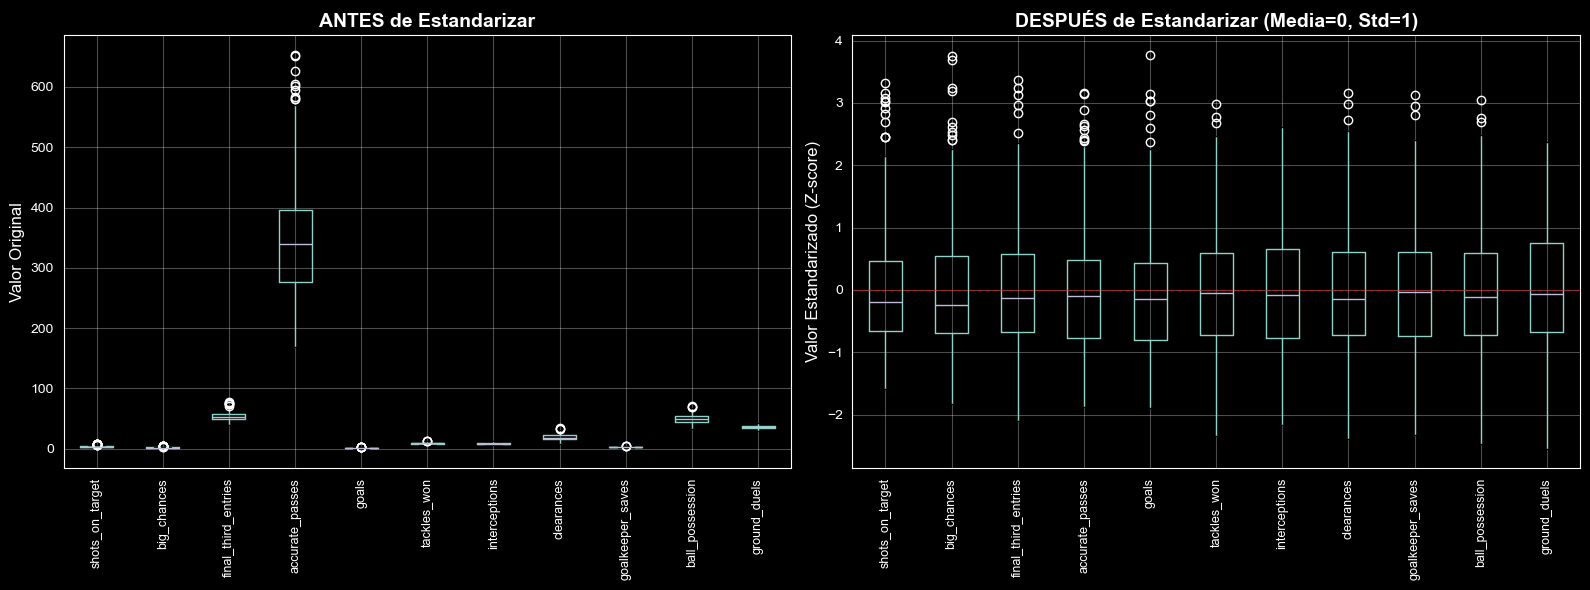


=== EJEMPLOS DE TRANSFORMACIÓN ===

Real Madrid 19/20 - home (ORIGINAL):
shots_on_target          7.105263
big_chances              3.157895
final_third_entries     60.631579
accurate_passes        518.052632
goals                    2.105263
tackles_won              8.789474
interceptions            9.894737
clearances              11.894737
goalkeeper_saves         2.526316
ball_possession         60.500000
ground_duels            41.578947
Name: 52, dtype: float64

Real Madrid 19/20 - home (ESTANDARIZADO):
shots_on_target        2.686680
big_chances            1.470471
final_third_entries    0.913585
accurate_passes        1.756916
goals                  1.719720
tackles_won           -0.504101
interceptions          0.803451
clearances            -1.592849
goalkeeper_saves      -0.417551
ball_possession        1.516104
ground_duels           1.921707
Name: 52, dtype: float64

=== PARÁMETROS DEL ESCALADOR (para interpretar luego) ===
                feature  media_original  std_ori

In [16]:
# Paso 1: Preparar los datos
print("=== ANTES DE ESTANDARIZAR ===")
print(df_final_features[final_features].describe().round(2))

# Paso 2: Crear el escalador
scaler = StandardScaler()

# Paso 3: Aplicar estandarización (solo a las features, no a team/year/location)
X_scaled = scaler.fit_transform(df_final_features[final_features])

# Convertir a DataFrame para mantener nombres de columnas
df_scaled = pd.DataFrame(
    X_scaled, 
    columns=final_features,
    index=df_final_features.index
)

# Añadir de vuelta las columnas identificadoras
df_scaled['team'] = df_final_features['team'].values
df_scaled['year'] = df_final_features['year'].values
df_scaled['location'] = df_final_features['location'].values

print("\n=== DESPUÉS DE ESTANDARIZAR ===")
print(df_scaled[final_features].describe().round(2))

# Verificación: Media ~0 y Desv. Estándar ~1
print("\n✅ VERIFICACIÓN DE ESTANDARIZACIÓN:")
print(f"Media de todas las features: {df_scaled[final_features].mean().mean():.6f} (debe ser ~0)")
print(f"Desv. Std de todas las features: {df_scaled[final_features].std().mean():.6f} (debe ser ~1)")

# Visualización: Comparación antes vs después
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Antes de estandarizar
ax1 = axes[0]
df_final_features[final_features].boxplot(ax=ax1, rot=90)
ax1.set_title('ANTES de Estandarizar', fontsize=14, fontweight='bold')
ax1.set_ylabel('Valor Original', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', labelsize=9)

# Después de estandarizar
ax2 = axes[1]
df_scaled[final_features].boxplot(ax=ax2, rot=90)
ax2.set_title('DESPUÉS de Estandarizar (Media=0, Std=1)', fontsize=14, fontweight='bold')
ax2.set_ylabel('Valor Estandarizado (Z-score)', fontsize=12)
ax2.axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', labelsize=9)

plt.tight_layout()
plt.show()

# Mostrar ejemplos de transformación
print("\n=== EJEMPLOS DE TRANSFORMACIÓN ===")
print("\nReal Madrid 19/20 - home (ORIGINAL):")
example_orig = df_final_features[(df_final_features['team'] == 'real-madrid') & 
                                 (df_final_features['year'] == '19/20') & 
                                 (df_final_features['location'] == 'home')]
if len(example_orig) > 0:
    print(example_orig[final_features].iloc[0])
    
    print("\nReal Madrid 19/20 - home (ESTANDARIZADO):")
    example_scaled = df_scaled[(df_scaled['team'] == 'real-madrid') & 
                               (df_scaled['year'] == '19/20') & 
                               (df_scaled['location'] == 'home')]
    print(example_scaled[final_features].iloc[0])

# Guardar media y desviación para referencia
print("\n=== PARÁMETROS DEL ESCALADOR (para interpretar luego) ===")
scaling_params = pd.DataFrame({
    'feature': final_features,
    'media_original': scaler.mean_,
    'std_original': scaler.scale_
}).round(2)
print(scaling_params)

print("\n✅ Estandarización completada")
print(f"📊 Dataset estandarizado: {len(df_scaled)} registros x {len(final_features)} features")

### 2.2. PCA

=== VARIANZA EXPLICADA POR CADA COMPONENTE ===
PC1: 46.20% (Acumulado: 46.20%)
PC2: 15.53% (Acumulado: 61.73%)
PC3: 10.63% (Acumulado: 72.36%)
PC4: 9.08% (Acumulado: 81.43%)
PC5: 5.87% (Acumulado: 87.30%)
PC6: 4.34% (Acumulado: 91.64%)
PC7: 3.39% (Acumulado: 95.03%)
PC8: 2.29% (Acumulado: 97.32%)
PC9: 1.24% (Acumulado: 98.56%)
PC10: 1.02% (Acumulado: 99.58%)
PC11: 0.42% (Acumulado: 100.00%)


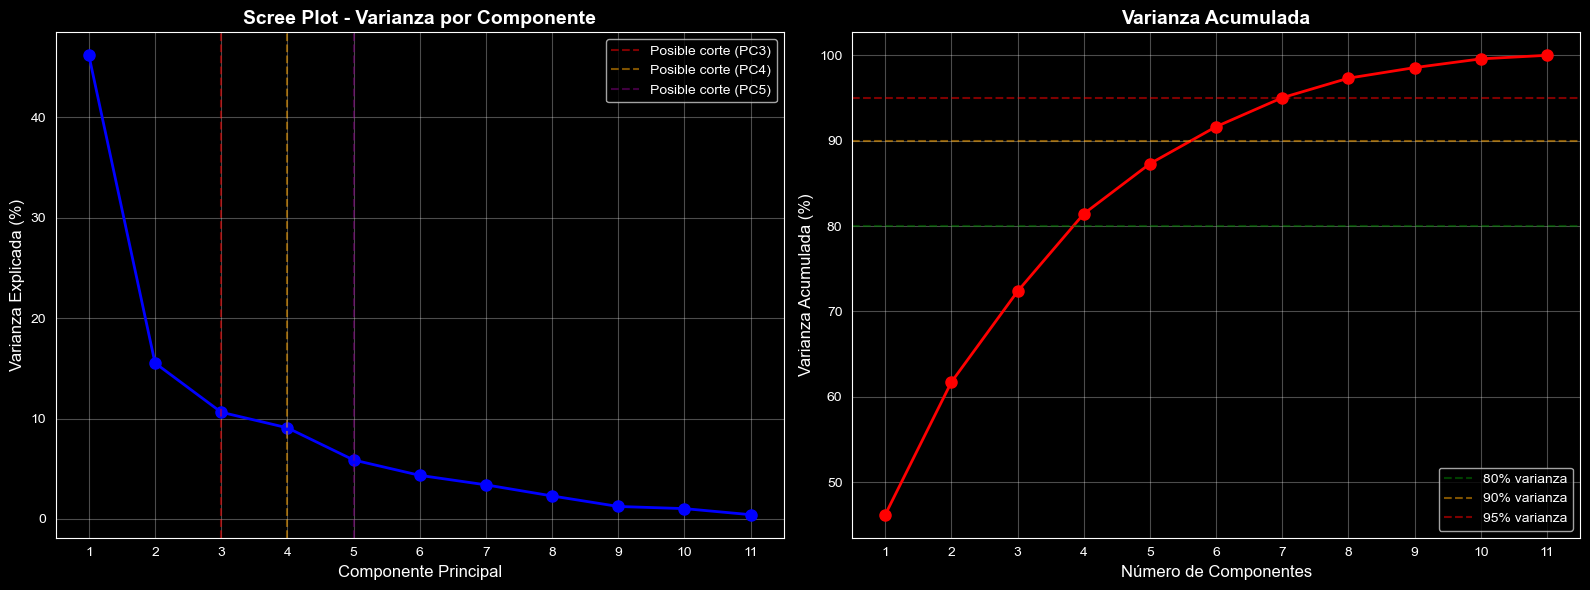


=== COMPONENTES NECESARIOS ===
Para explicar 80% de varianza: 4 componentes (81.43%)
Para explicar 90% de varianza: 6 componentes (91.64%)
Para explicar 95% de varianza: 7 componentes (95.03%)

=== CARGAS (LOADINGS) DE LOS PRIMEROS 4 COMPONENTES ===
                       PC1    PC2    PC3    PC4
shots_on_target      0.405  0.064 -0.069  0.028
big_chances          0.381  0.098 -0.233 -0.039
final_third_entries  0.223 -0.270 -0.064  0.669
accurate_passes      0.387  0.122 -0.009 -0.272
goals                0.384  0.050 -0.121 -0.171
tackles_won         -0.027  0.575  0.305  0.476
interceptions       -0.139 -0.387  0.552 -0.263
clearances          -0.283  0.374 -0.277  0.030
goalkeeper_saves    -0.242  0.343 -0.253 -0.347
ball_possession      0.391  0.025  0.043 -0.145
ground_duels         0.178  0.397  0.618 -0.099


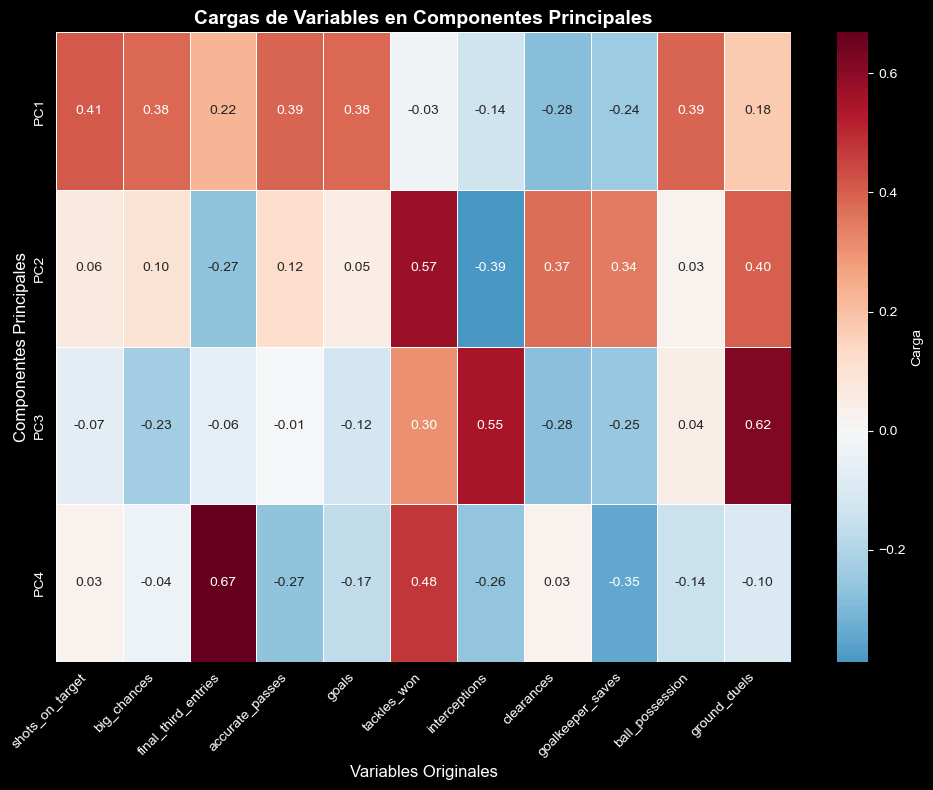


=== INTERPRETACIÓN DE COMPONENTES PRINCIPALES ===

🎯 PC1 (Varianza: 46.20%):
  Contribuciones POSITIVAS (↑):
    • shots_on_target: 0.405
    • ball_possession: 0.391
    • accurate_passes: 0.387
  Contribuciones NEGATIVAS (↓):
    • clearances: -0.283
    • goalkeeper_saves: -0.242
    • interceptions: -0.139

🎯 PC2 (Varianza: 15.53%):
  Contribuciones POSITIVAS (↑):
    • tackles_won: 0.575
    • ground_duels: 0.397
    • clearances: 0.374
  Contribuciones NEGATIVAS (↓):
    • interceptions: -0.387
    • final_third_entries: -0.270
    • ball_possession: 0.025

🎯 PC3 (Varianza: 10.63%):
  Contribuciones POSITIVAS (↑):
    • ground_duels: 0.618
    • interceptions: 0.552
    • tackles_won: 0.305
  Contribuciones NEGATIVAS (↓):
    • clearances: -0.277
    • goalkeeper_saves: -0.253
    • big_chances: -0.233

🎯 PC4 (Varianza: 9.08%):
  Contribuciones POSITIVAS (↑):
    • final_third_entries: 0.669
    • tackles_won: 0.476
    • clearances: 0.030
  Contribuciones NEGATIVAS (↓):
    • g

In [17]:
# Paso 1: Aplicar PCA con TODOS los componentes (11)
# Primero vemos cuánta varianza explica cada uno
pca_full = PCA(n_components=11)
X_pca_full = pca_full.fit_transform(df_scaled[final_features])

# Varianza explicada por cada componente
explained_variance = pca_full.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

print("=== VARIANZA EXPLICADA POR CADA COMPONENTE ===")
for i, (var, cum_var) in enumerate(zip(explained_variance, cumulative_variance), 1):
    print(f"PC{i}: {var*100:.2f}% (Acumulado: {cum_var*100:.2f}%)")

# Visualización 1: Scree Plot (Método del Codo para PCA)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Varianza individual
ax1 = axes[0]
components = range(1, len(explained_variance) + 1)
ax1.plot(components, explained_variance * 100, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Componente Principal', fontsize=12)
ax1.set_ylabel('Varianza Explicada (%)', fontsize=12)
ax1.set_title('Scree Plot - Varianza por Componente', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_xticks(components)

# Marcar el "codo"
ax1.axvline(x=3, color='red', linestyle='--', alpha=0.5, label='Posible corte (PC3)')
ax1.axvline(x=4, color='orange', linestyle='--', alpha=0.5, label='Posible corte (PC4)')
ax1.axvline(x=5, color='purple', linestyle='--', alpha=0.5, label='Posible corte (PC5)')
ax1.legend()

# Gráfico 2: Varianza acumulada
ax2 = axes[1]
ax2.plot(components, cumulative_variance * 100, 'ro-', linewidth=2, markersize=8)
ax2.set_xlabel('Número de Componentes', fontsize=12)
ax2.set_ylabel('Varianza Acumulada (%)', fontsize=12)
ax2.set_title('Varianza Acumulada', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_xticks(components)

# Líneas de referencia
ax2.axhline(y=80, color='green', linestyle='--', alpha=0.5, label='80% varianza')
ax2.axhline(y=90, color='orange', linestyle='--', alpha=0.5, label='90% varianza')
ax2.axhline(y=95, color='red', linestyle='--', alpha=0.5, label='95% varianza')
ax2.legend()

plt.tight_layout()
plt.show()

# Encontrar número de componentes para 80%, 90%, 95%
n_comp_80 = np.argmax(cumulative_variance >= 0.80) + 1
n_comp_90 = np.argmax(cumulative_variance >= 0.90) + 1
n_comp_95 = np.argmax(cumulative_variance >= 0.95) + 1

print(f"\n=== COMPONENTES NECESARIOS ===")
print(f"Para explicar 80% de varianza: {n_comp_80} componentes ({cumulative_variance[n_comp_80-1]*100:.2f}%)")
print(f"Para explicar 90% de varianza: {n_comp_90} componentes ({cumulative_variance[n_comp_90-1]*100:.2f}%)")
print(f"Para explicar 95% de varianza: {n_comp_95} componentes ({cumulative_variance[n_comp_95-1]*100:.2f}%)")

# Paso 2: Interpretar los componentes principales
# Vamos a ver las cargas (loadings) de cada variable en los primeros 4 PCs
n_show = 4  # Mostrar primeros 4 componentes

loadings = pd.DataFrame(
    pca_full.components_[:n_show, :].T,
    columns=[f'PC{i+1}' for i in range(n_show)],
    index=final_features
)

print(f"\n=== CARGAS (LOADINGS) DE LOS PRIMEROS {n_show} COMPONENTES ===")
print(loadings.round(3))

# Visualización 2: Heatmap de loadings
plt.figure(figsize=(10, 8))
sns.heatmap(loadings.T, 
            annot=True, 
            fmt='.2f',
            cmap='RdBu_r',
            center=0,
            cbar_kws={'label': 'Carga'},
            linewidths=0.5)
plt.title('Cargas de Variables en Componentes Principales', fontsize=14, fontweight='bold')
plt.xlabel('Variables Originales', fontsize=12)
plt.ylabel('Componentes Principales', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Identificar qué representa cada componente
print("\n=== INTERPRETACIÓN DE COMPONENTES PRINCIPALES ===")
for i in range(n_show):
    print(f"\n🎯 PC{i+1} (Varianza: {explained_variance[i]*100:.2f}%):")
    
    # Top 3 contribuciones positivas
    top_positive = loadings[f'PC{i+1}'].nlargest(3)
    print("  Contribuciones POSITIVAS (↑):")
    for var, val in top_positive.items():
        print(f"    • {var}: {val:.3f}")
    
    # Top 3 contribuciones negativas
    top_negative = loadings[f'PC{i+1}'].nsmallest(3)
    print("  Contribuciones NEGATIVAS (↓):")
    for var, val in top_negative.items():
        print(f"    • {var}: {val:.3f}")

print("\n" + "="*80)
print("🎯 RECOMENDACIÓN: ¿Cuántos componentes usar?")
print("="*80)
print(f"Opción conservadora: {n_comp_80} componentes (80% varianza)")
print(f"Opción equilibrada: {n_comp_90} componentes (90% varianza)")
print(f"Opción completa: {n_comp_95} componentes (95% varianza)")

✅ PCA aplicado con 4 componentes
📊 Varianza explicada: 81.43%

=== LOADINGS FINALES (4 COMPONENTES) ===
                       PC1    PC2    PC3    PC4
shots_on_target      0.405  0.064 -0.069  0.028
big_chances          0.381  0.098 -0.233 -0.039
final_third_entries  0.223 -0.270 -0.064  0.669
accurate_passes      0.387  0.122 -0.009 -0.272
goals                0.384  0.050 -0.121 -0.171
tackles_won         -0.027  0.575  0.305  0.476
interceptions       -0.139 -0.387  0.552 -0.263
clearances          -0.283  0.374 -0.277  0.030
goalkeeper_saves    -0.242  0.343 -0.253 -0.347
ball_possession      0.391  0.025  0.043 -0.145
ground_duels         0.178  0.397  0.618 -0.099

=== INTERPRETACIÓN DE LOS 4 COMPONENTES PRINCIPALES ===

PC1 - Varianza explicada: 46.20%
🔵 CARGAS POSITIVAS MÁS FUERTES:
   • shots_on_target: 0.405
   • ball_possession: 0.391
   • accurate_passes: 0.387
🔴 CARGAS NEGATIVAS MÁS FUERTES:
   • clearances: -0.283
   • goalkeeper_saves: -0.242
   • interceptions: -0.139


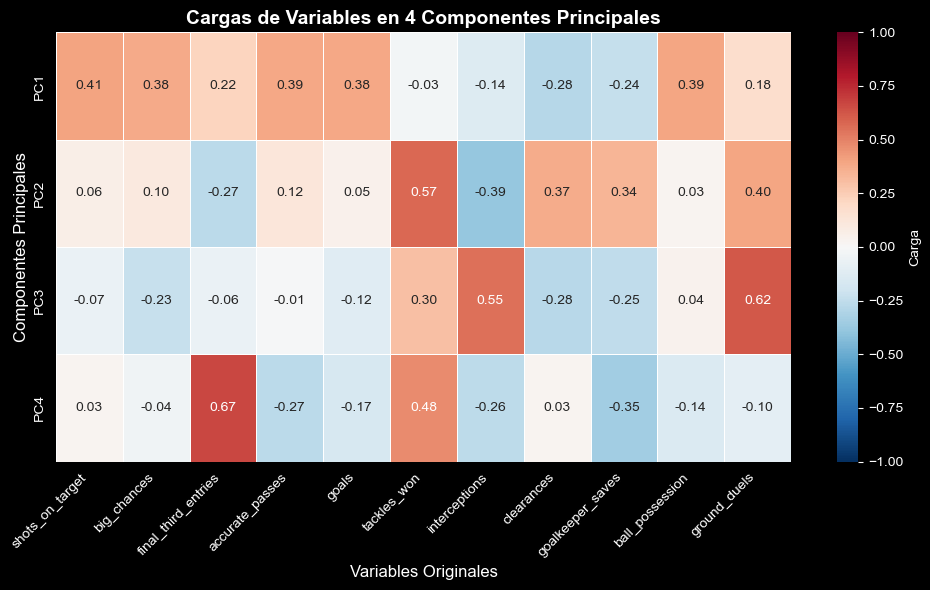


=== EJEMPLOS EN ESPACIO PCA ===
        PC1       PC2       PC3       PC4             team   year location
0 -2.223103 -0.077121 -0.760379 -0.373088          granada  21/22     away
1 -0.525042  1.643460  0.465881 -0.558401       real-betis  24/25     away
2 -1.532336 -1.586769  0.003441 -1.552429         valencia  20/21     away
3 -2.955813  0.689927 -0.873354  0.584342            cadiz  23/24     away
4  1.050345  0.893863 -0.252134 -0.174690          almeria  23/24     home
5 -2.231077 -2.256191 -0.536356 -0.741816          granada  20/21     away
6 -0.222206  0.810226 -0.394600 -1.545299        girona-fc  22/23     away
7  0.330764  1.137619  0.221138  0.772897         valencia  24/25     home
8 -2.060377  0.872160 -0.019923 -0.032686   rayo-vallecano  23/24     away
9 -2.677290  2.794082  1.750234 -0.419342  real-valladolid  22/23     away


In [18]:
# Aplicar PCA final con 4 componentes
n_components_final = 4

pca_final = PCA(n_components=n_components_final)
X_pca = pca_final.fit_transform(df_scaled[final_features])

# Crear DataFrame con los componentes
df_pca = pd.DataFrame(
    X_pca,
    columns=[f'PC{i+1}' for i in range(n_components_final)]
)

# Añadir información de identificación
df_pca['team'] = df_scaled['team'].values
df_pca['year'] = df_scaled['year'].values
df_pca['location'] = df_scaled['location'].values

print(f"✅ PCA aplicado con {n_components_final} componentes")
print(f"📊 Varianza explicada: {pca_final.explained_variance_ratio_.sum()*100:.2f}%")

# Mostrar loadings de los 4 componentes
loadings_final = pd.DataFrame(
    pca_final.components_.T,
    columns=[f'PC{i+1}' for i in range(n_components_final)],
    index=final_features
)

print("\n=== LOADINGS FINALES (4 COMPONENTES) ===")
print(loadings_final.round(3))

# Interpretar cada componente
print("\n=== INTERPRETACIÓN DE LOS 4 COMPONENTES PRINCIPALES ===")
for i in range(n_components_final):
    print(f"\n{'='*80}")
    print(f"PC{i+1} - Varianza explicada: {pca_final.explained_variance_ratio_[i]*100:.2f}%")
    print('='*80)
    
    # Top 3 cargas positivas
    top_pos = loadings_final[f'PC{i+1}'].nlargest(3)
    print("🔵 CARGAS POSITIVAS MÁS FUERTES:")
    for var, val in top_pos.items():
        print(f"   • {var}: {val:.3f}")
    
    # Top 3 cargas negativas
    top_neg = loadings_final[f'PC{i+1}'].nsmallest(3)
    print("🔴 CARGAS NEGATIVAS MÁS FUERTES:")
    for var, val in top_neg.items():
        print(f"   • {var}: {val:.3f}")

# Heatmap de loadings
plt.figure(figsize=(10, 6))
sns.heatmap(loadings_final.T, 
            annot=True, 
            fmt='.2f',
            cmap='RdBu_r',
            center=0,
            cbar_kws={'label': 'Carga'},
            linewidths=0.5,
            vmin=-1, vmax=1)
plt.title('Cargas de Variables en 4 Componentes Principales', fontsize=14, fontweight='bold')
plt.xlabel('Variables Originales', fontsize=12)
plt.ylabel('Componentes Principales', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Ver ejemplos de equipos en el espacio PCA
print("\n=== EJEMPLOS EN ESPACIO PCA ===")
print(df_pca.head(10))

- PC1 (~45% varianza): "CALIDAD OFENSIVA TOTAL" 🥇: Equipos dominantes en juego y en ocasiones. Equipos de arriba
- PC2 (~16% varianza): "SOLIDEZ DEFENSIVA" 🛡️: Equipos fuertes en su campo, equipos con bloque medio-bajo de presión. Suelen ser defensivos.
- PC3 (~11% varianza): "INTENSIDAD DEFENSIVA" 💪: Equipos fuertes en la recuperación.
- PC4 (~9% varianza): "PRESIÓN ALTA vs DEFENSA PROFUNDA" ⚡: Equipos que presionan muy alto, dejando espacios atrás.

### 2.3. CLUSTERING

In [19]:
# Preparar datos para clustering
X_clustering = df_pca[['PC1', 'PC2', 'PC3', 'PC4']].values

print(f"✅ Datos preparados para clustering")
print(f"📊 {len(X_clustering)} registros x 4 componentes principales")
print(f"📈 Varianza explicada total: {pca_final.explained_variance_ratio_.sum()*100:.2f}%")

# Estadísticas de los componentes
print("\n=== ESTADÍSTICAS DE LOS COMPONENTES ===")
print(df_pca[['PC1', 'PC2', 'PC3', 'PC4']].describe().round(2))

✅ Datos preparados para clustering
📊 280 registros x 4 componentes principales
📈 Varianza explicada total: 81.43%

=== ESTADÍSTICAS DE LOS COMPONENTES ===
          PC1     PC2     PC3     PC4
count  280.00  280.00  280.00  280.00
mean     0.00   -0.00    0.00    0.00
std      2.26    1.31    1.08    1.00
min     -4.18   -3.92   -2.65   -2.31
25%     -1.61   -0.86   -0.77   -0.66
50%     -0.47   -0.05   -0.05   -0.00
75%      1.23    0.97    0.79    0.67
max      8.02    2.91    2.42    2.96


#### 2.3.1. Método del codo + Silhouette Score

📊 Datos para clustering: (280, 4)

=== EVALUANDO NÚMERO ÓPTIMO DE CLUSTERS ===

k=2 → Inercia: 1592.36, Silhouette: 0.320
k=3 → Inercia: 1300.45, Silhouette: 0.244
k=4 → Inercia: 1071.39, Silhouette: 0.245
k=5 → Inercia: 950.29, Silhouette: 0.227
k=6 → Inercia: 870.02, Silhouette: 0.214
k=7 → Inercia: 798.29, Silhouette: 0.214
k=8 → Inercia: 742.77, Silhouette: 0.218
k=9 → Inercia: 686.81, Silhouette: 0.222
k=10 → Inercia: 651.16, Silhouette: 0.210


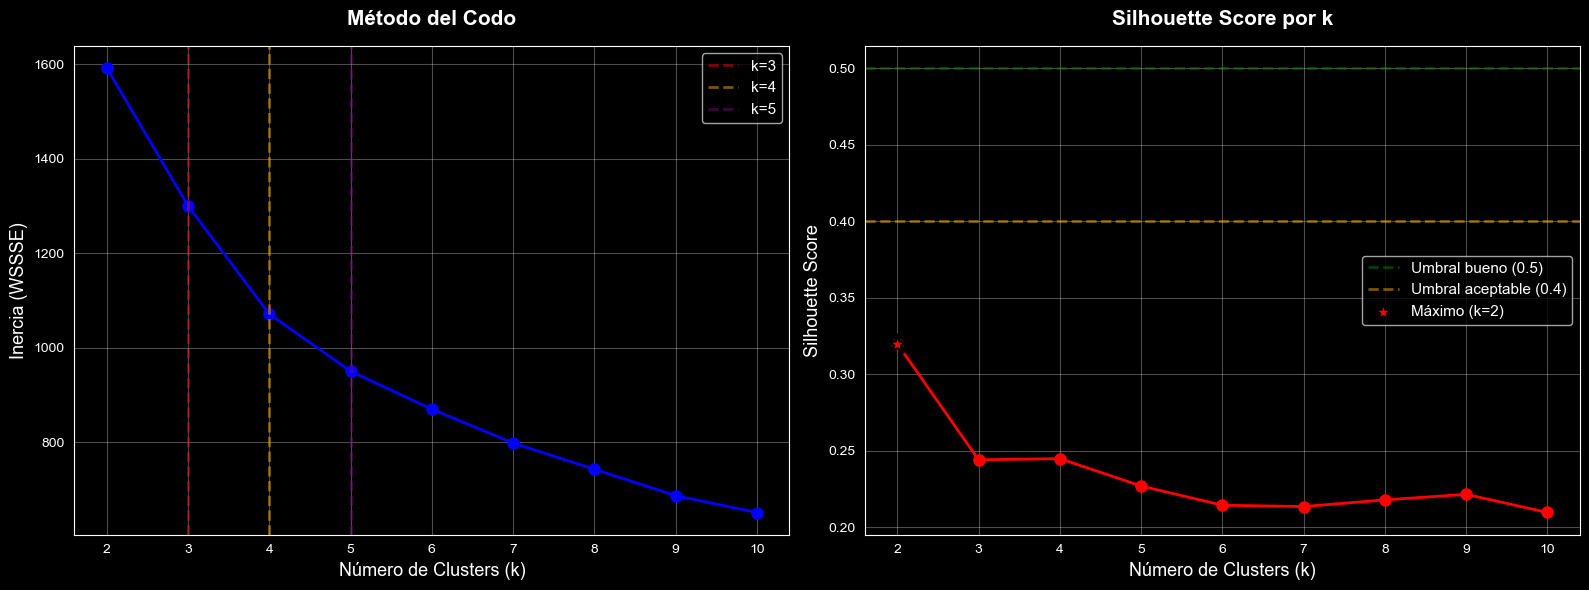


🎯 RECOMENDACIÓN DE K ÓPTIMO

📊 Según Silhouette Score máximo:
   k = 2 (score: 0.320)

📉 Según Método del Codo (segunda derivada):
   k ≈ 5

📋 COMPARACIÓN DETALLADA (k=3, 4, 5)
 k     Inercia  Silhouette Mejora_Inercia Mejora_Silhouette
 3 1300.452242    0.244143              -                 -
 4 1071.394211    0.244930         229.06             0.001
 5  950.291812    0.227036         121.10            -0.018

💡 INTERPRETACIÓN
• Silhouette > 0.5: Estructura de clusters clara
• Silhouette 0.4-0.5: Estructura razonable
• Silhouette < 0.4: Estructura débil

• Busca el 'codo' donde la inercia deja de bajar significativamente
• Considera el equilibrio entre complejidad (más clusters) e interpretabilidad


In [20]:
# Preparar datos para clustering
X_clustering = df_pca[['PC1', 'PC2', 'PC3', 'PC4']].values

print(f"📊 Datos para clustering: {X_clustering.shape}")

# Probar diferentes valores de k
k_values = range(2, 11)
inertias = []
silhouette_scores = []

print("\n=== EVALUANDO NÚMERO ÓPTIMO DE CLUSTERS ===\n")

for k in k_values:
    # Entrenar KMeans
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
    cluster_labels = kmeans.fit_predict(X_clustering)
    
    # Calcular inercia (WSSSE)
    inertia = kmeans.inertia_
    inertias.append(inertia)
    
    # Calcular Silhouette Score
    silhouette = silhouette_score(X_clustering, cluster_labels)
    silhouette_scores.append(silhouette)
    
    print(f"k={k} → Inercia: {inertia:.2f}, Silhouette: {silhouette:.3f}")

# Visualizar método del codo y silhouette
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Método del codo
ax1 = axes[0]
ax1.plot(k_values, inertias, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Número de Clusters (k)', fontsize=13)
ax1.set_ylabel('Inercia (WSSSE)', fontsize=13)
ax1.set_title('Método del Codo', fontsize=15, fontweight='bold', pad=15)
ax1.grid(True, alpha=0.3)
ax1.set_xticks(k_values)

# Marcar posibles codos
ax1.axvline(x=3, color='red', linestyle='--', alpha=0.5, linewidth=2, label='k=3')
ax1.axvline(x=4, color='orange', linestyle='--', alpha=0.5, linewidth=2, label='k=4')
ax1.axvline(x=5, color='purple', linestyle='--', alpha=0.5, linewidth=2, label='k=5')
ax1.legend(fontsize=11)

# Gráfico 2: Silhouette Score
ax2 = axes[1]
ax2.plot(k_values, silhouette_scores, 'ro-', linewidth=2, markersize=8)
ax2.set_xlabel('Número de Clusters (k)', fontsize=13)
ax2.set_ylabel('Silhouette Score', fontsize=13)
ax2.set_title('Silhouette Score por k', fontsize=15, fontweight='bold', pad=15)
ax2.grid(True, alpha=0.3)
ax2.set_xticks(k_values)
ax2.axhline(y=0.5, color='green', linestyle='--', alpha=0.5, linewidth=2, label='Umbral bueno (0.5)')
ax2.axhline(y=0.4, color='orange', linestyle='--', alpha=0.5, linewidth=2, label='Umbral aceptable (0.4)')
ax2.legend(fontsize=11)

# Marcar el máximo silhouette
max_silhouette_idx = np.argmax(silhouette_scores)
max_k = k_values[max_silhouette_idx]
ax2.scatter(max_k, silhouette_scores[max_silhouette_idx], 
            s=200, c='red', marker='*', edgecolors='black', linewidths=2,
            label=f'Máximo (k={max_k})', zorder=5)
ax2.legend(fontsize=11)

plt.tight_layout()
plt.show()

# Encontrar el k óptimo automáticamente
print("\n" + "="*80)
print("🎯 RECOMENDACIÓN DE K ÓPTIMO")
print("="*80)

# Método 1: Máximo Silhouette
max_silhouette_k = k_values[np.argmax(silhouette_scores)]
print(f"\n📊 Según Silhouette Score máximo:")
print(f"   k = {max_silhouette_k} (score: {silhouette_scores[max_silhouette_k-2]:.3f})")

# Método 2: Método del codo (calcular segunda derivada)
# Aproximación simple: encontrar donde la mejora se reduce drásticamente
differences = np.diff(inertias)
second_diff = np.diff(differences)
elbow_k = k_values[np.argmax(second_diff) + 2]  # +2 por los dos diff
print(f"\n📉 Según Método del Codo (segunda derivada):")
print(f"   k ≈ {elbow_k}")

# Método 3: Silhouette > 0.4 y k más bajo
acceptable_k = [k for k, s in zip(k_values, silhouette_scores) if s > 0.4]
if acceptable_k:
    print(f"\n✅ Valores de k con Silhouette > 0.4:")
    for k in acceptable_k:
        print(f"   k = {k}: {silhouette_scores[k-2]:.3f}")

# Análisis comparativo para k=3, 4, 5
print("\n" + "="*80)
print("📋 COMPARACIÓN DETALLADA (k=3, 4, 5)")
print("="*80)

comparison_table = []
for k in [3, 4, 5]:
    idx = k - 2
    comparison_table.append({
        'k': k,
        'Inercia': inertias[idx],
        'Silhouette': silhouette_scores[idx],
        'Mejora_Inercia': '-' if k == 3 else f"{(inertias[idx-1] - inertias[idx]):.2f}",
        'Mejora_Silhouette': '-' if k == 3 else f"{(silhouette_scores[idx] - silhouette_scores[idx-1]):.3f}"
    })

comparison_df = pd.DataFrame(comparison_table)
print(comparison_df.to_string(index=False))

print("\n" + "="*80)
print("💡 INTERPRETACIÓN")
print("="*80)
print("• Silhouette > 0.5: Estructura de clusters clara")
print("• Silhouette 0.4-0.5: Estructura razonable")
print("• Silhouette < 0.4: Estructura débil")
print("\n• Busca el 'codo' donde la inercia deja de bajar significativamente")
print("• Considera el equilibrio entre complejidad (más clusters) e interpretabilidad")

In [21]:
# Opción 1: k=4
kmeans_4 = KMeans(n_clusters=4, random_state=42, n_init=20, max_iter=300)
clusters_4 = kmeans_4.fit_predict(X_clustering)

# Opción 2: k=5
kmeans_5 = KMeans(n_clusters=5, random_state=42, n_init=20, max_iter=300)
clusters_5 = kmeans_5.fit_predict(X_clustering)

# Añadir al dataframe
df_pca['cluster_k4'] = clusters_4
df_pca['cluster_k5'] = clusters_5

print(f"\n✅ Clustering completado con k=4 y k=5")

# Ver distribución
print("\n=== DISTRIBUCIÓN DE CLUSTERS ===")
print("\nk=4:")
print(df_pca['cluster_k4'].value_counts().sort_index())
print("\nk=5:")
print(df_pca['cluster_k5'].value_counts().sort_index())

# Caracterizar cada cluster por los componentes principales
print("\n=== PERFILES DE CLUSTERS (k=4) ===")
cluster_profiles_4 = df_pca.groupby('cluster_k4')[['PC1', 'PC2', 'PC3', 'PC4']].mean()
print(cluster_profiles_4.round(2))

print("\n=== PERFILES DE CLUSTERS (k=5) ===")
cluster_profiles_5 = df_pca.groupby('cluster_k5')[['PC1', 'PC2', 'PC3', 'PC4']].mean()
print(cluster_profiles_5.round(2))


✅ Clustering completado con k=4 y k=5

=== DISTRIBUCIÓN DE CLUSTERS ===

k=4:
cluster_k4
0    93
1    31
2    96
3    60
Name: count, dtype: int64

k=5:
cluster_k5
0    70
1    54
2    74
3    52
4    30
Name: count, dtype: int64

=== PERFILES DE CLUSTERS (k=4) ===
             PC1   PC2   PC3   PC4
cluster_k4                        
0          -1.71  0.87 -0.28 -0.19
1           4.72  0.17 -0.19 -0.20
2           0.99  0.13  0.26  0.02
3          -1.38 -1.66  0.12  0.37

=== PERFILES DE CLUSTERS (k=5) ===
             PC1   PC2   PC3   PC4
cluster_k5                        
0           1.26 -0.24 -0.07 -0.08
1          -1.31 -1.76  0.21  0.42
2          -1.90  0.56 -0.72 -0.36
3          -0.39  1.23  1.00  0.29
4           4.78  0.20 -0.17 -0.19


In [22]:
# Usar k=4 como solución final
df_pca['cluster'] = df_pca['cluster_k4']

# Ordenar por PC1 (calidad ofensiva) para asignar etiquetas coherentes
cluster_order = df_pca.groupby('cluster')['PC1'].mean().sort_values(ascending=False)
print("\n=== CLUSTERS ORDENADOS POR PC1 (CALIDAD OFENSIVA) ===")
print(cluster_order)

# Asignar etiquetas interpretables
cluster_mapping = {}
sorted_clusters = cluster_order.index.tolist()

cluster_mapping[sorted_clusters[0]] = "Dominadores Élite"
cluster_mapping[sorted_clusters[1]] = "Equilibrados Sólidos"
cluster_mapping[sorted_clusters[2]] = "Defensivos En Riesgo" 
cluster_mapping[sorted_clusters[3]] = "Intensidad Alta"

df_pca['cluster_label'] = df_pca['cluster'].map(cluster_mapping)

print("\n=== ETIQUETAS ASIGNADAS ===")
for cluster_id, label in cluster_mapping.items():
    count = len(df_pca[df_pca['cluster'] == cluster_id])
    print(f"Cluster {cluster_id}: {label} ({count} equipos)")

# Ver ejemplos de cada cluster
print("\n=== EJEMPLOS POR CLUSTER ===")
for cluster_id in sorted_clusters:
    label = cluster_mapping[cluster_id]
    print(f"\n{label}:")
    examples = df_pca[df_pca['cluster'] == cluster_id][['team', 'year', 'location']].head(5)
    print(examples.to_string(index=False))


=== CLUSTERS ORDENADOS POR PC1 (CALIDAD OFENSIVA) ===
cluster
1    4.722283
2    0.989750
3   -1.376846
0   -1.707484
Name: PC1, dtype: float64

=== ETIQUETAS ASIGNADAS ===
Cluster 1: Dominadores Élite (31 equipos)
Cluster 2: Equilibrados Sólidos (96 equipos)
Cluster 3: Defensivos En Riesgo (60 equipos)
Cluster 0: Intensidad Alta (93 equipos)

=== EJEMPLOS POR CLUSTER ===

Dominadores Élite:
           team  year location
     villarreal 21/22     home
    real-madrid 22/23     home
atletico-madrid 25/26     home
    real-madrid 19/20     home
      barcelona 21/22     away

Equilibrados Sólidos:
           team  year location
        almeria 23/24     home
       valencia 24/25     home
  real-sociedad 25/26     home
real-valladolid 22/23     home
     celta-vigo 19/20     home

Defensivos En Riesgo:
    team  year location
valencia 20/21     away
 granada 20/21     away
  huesca 20/21     away
   cadiz 21/22     home
   elche 20/21     away

Intensidad Alta:
          team  year loc

In [23]:
# Análisis detallado por cluster
print("\n" + "="*80)
print("ANÁLISIS DETALLADO DE CLUSTERS")
print("="*80)

for cluster_id in sorted_clusters:
    label = cluster_mapping[cluster_id]
    df_cluster = df_pca[df_pca['cluster'] == cluster_id]
    
    print(f"\n{'='*80}")
    print(f"{label} (n={len(df_cluster)})")
    print('='*80)
    
    # Estadísticas de componentes principales
    print("\n📊 Componentes Principales (media):")
    pc_means = df_cluster[['PC1', 'PC2', 'PC3', 'PC4']].mean()
    print(f"  PC1 (Calidad Ofensiva):    {pc_means['PC1']:+.2f}")
    print(f"  PC2 (Solidez Defensiva):   {pc_means['PC2']:+.2f}")
    print(f"  PC3 (Intensidad):          {pc_means['PC3']:+.2f}")
    print(f"  PC4 (Presión Alta):        {pc_means['PC4']:+.2f}")
    
    # Distribución home/away
    print("\n🏟️ Distribución Local/Visitante:")
    location_dist = df_cluster['location'].value_counts()
    for loc, count in location_dist.items():
        pct = count / len(df_cluster) * 100
        print(f"  {loc}: {count} ({pct:.1f}%)")
    
    # Top 10 equipos más frecuentes
    print("\n🔝 Top 10 equipos más frecuentes:")
    top_teams = df_cluster['team'].value_counts().head(10)
    for team, count in top_teams.items():
        print(f"  {team}: {count} apariciones")

# Análisis general: ¿El factor local/visitante importa?
print("\n" + "="*80)
print("🏟️ ANÁLISIS HOME vs AWAY POR CLUSTER")
print("="*80)

for cluster_id in sorted_clusters:
    label = cluster_mapping[cluster_id]
    df_cluster = df_pca[df_pca['cluster'] == cluster_id]
    
    home_pct = (df_cluster['location'] == 'home').sum() / len(df_cluster) * 100
    away_pct = (df_cluster['location'] == 'away').sum() / len(df_cluster) * 100
    
    print(f"\n{label}:")
    print(f"  Home: {home_pct:.1f}% | Away: {away_pct:.1f}%")
    
    if home_pct > 70:
        print(f"  → Predominantemente equipos EN CASA")
    elif away_pct > 70:
        print(f"  → Predominantemente equipos FUERA")
    else:
        print(f"  → Mix balanceado")


ANÁLISIS DETALLADO DE CLUSTERS

Dominadores Élite (n=31)

📊 Componentes Principales (media):
  PC1 (Calidad Ofensiva):    +4.72
  PC2 (Solidez Defensiva):   +0.17
  PC3 (Intensidad):          -0.19
  PC4 (Presión Alta):        -0.20

🏟️ Distribución Local/Visitante:
  home: 20 (64.5%)
  away: 11 (35.5%)

🔝 Top 10 equipos más frecuentes:
  barcelona: 14 apariciones
  real-madrid: 10 apariciones
  atletico-madrid: 3 apariciones
  villarreal: 2 apariciones
  athletic-club: 1 apariciones
  girona-fc: 1 apariciones

Equilibrados Sólidos (n=96)

📊 Componentes Principales (media):
  PC1 (Calidad Ofensiva):    +0.99
  PC2 (Solidez Defensiva):   +0.13
  PC3 (Intensidad):          +0.26
  PC4 (Presión Alta):        +0.02

🏟️ Distribución Local/Visitante:
  home: 67 (69.8%)
  away: 29 (30.2%)

🔝 Top 10 equipos más frecuentes:
  real-sociedad: 12 apariciones
  atletico-madrid: 10 apariciones
  sevilla: 10 apariciones
  real-betis: 10 apariciones
  villarreal: 9 apariciones
  celta-vigo: 9 aparici

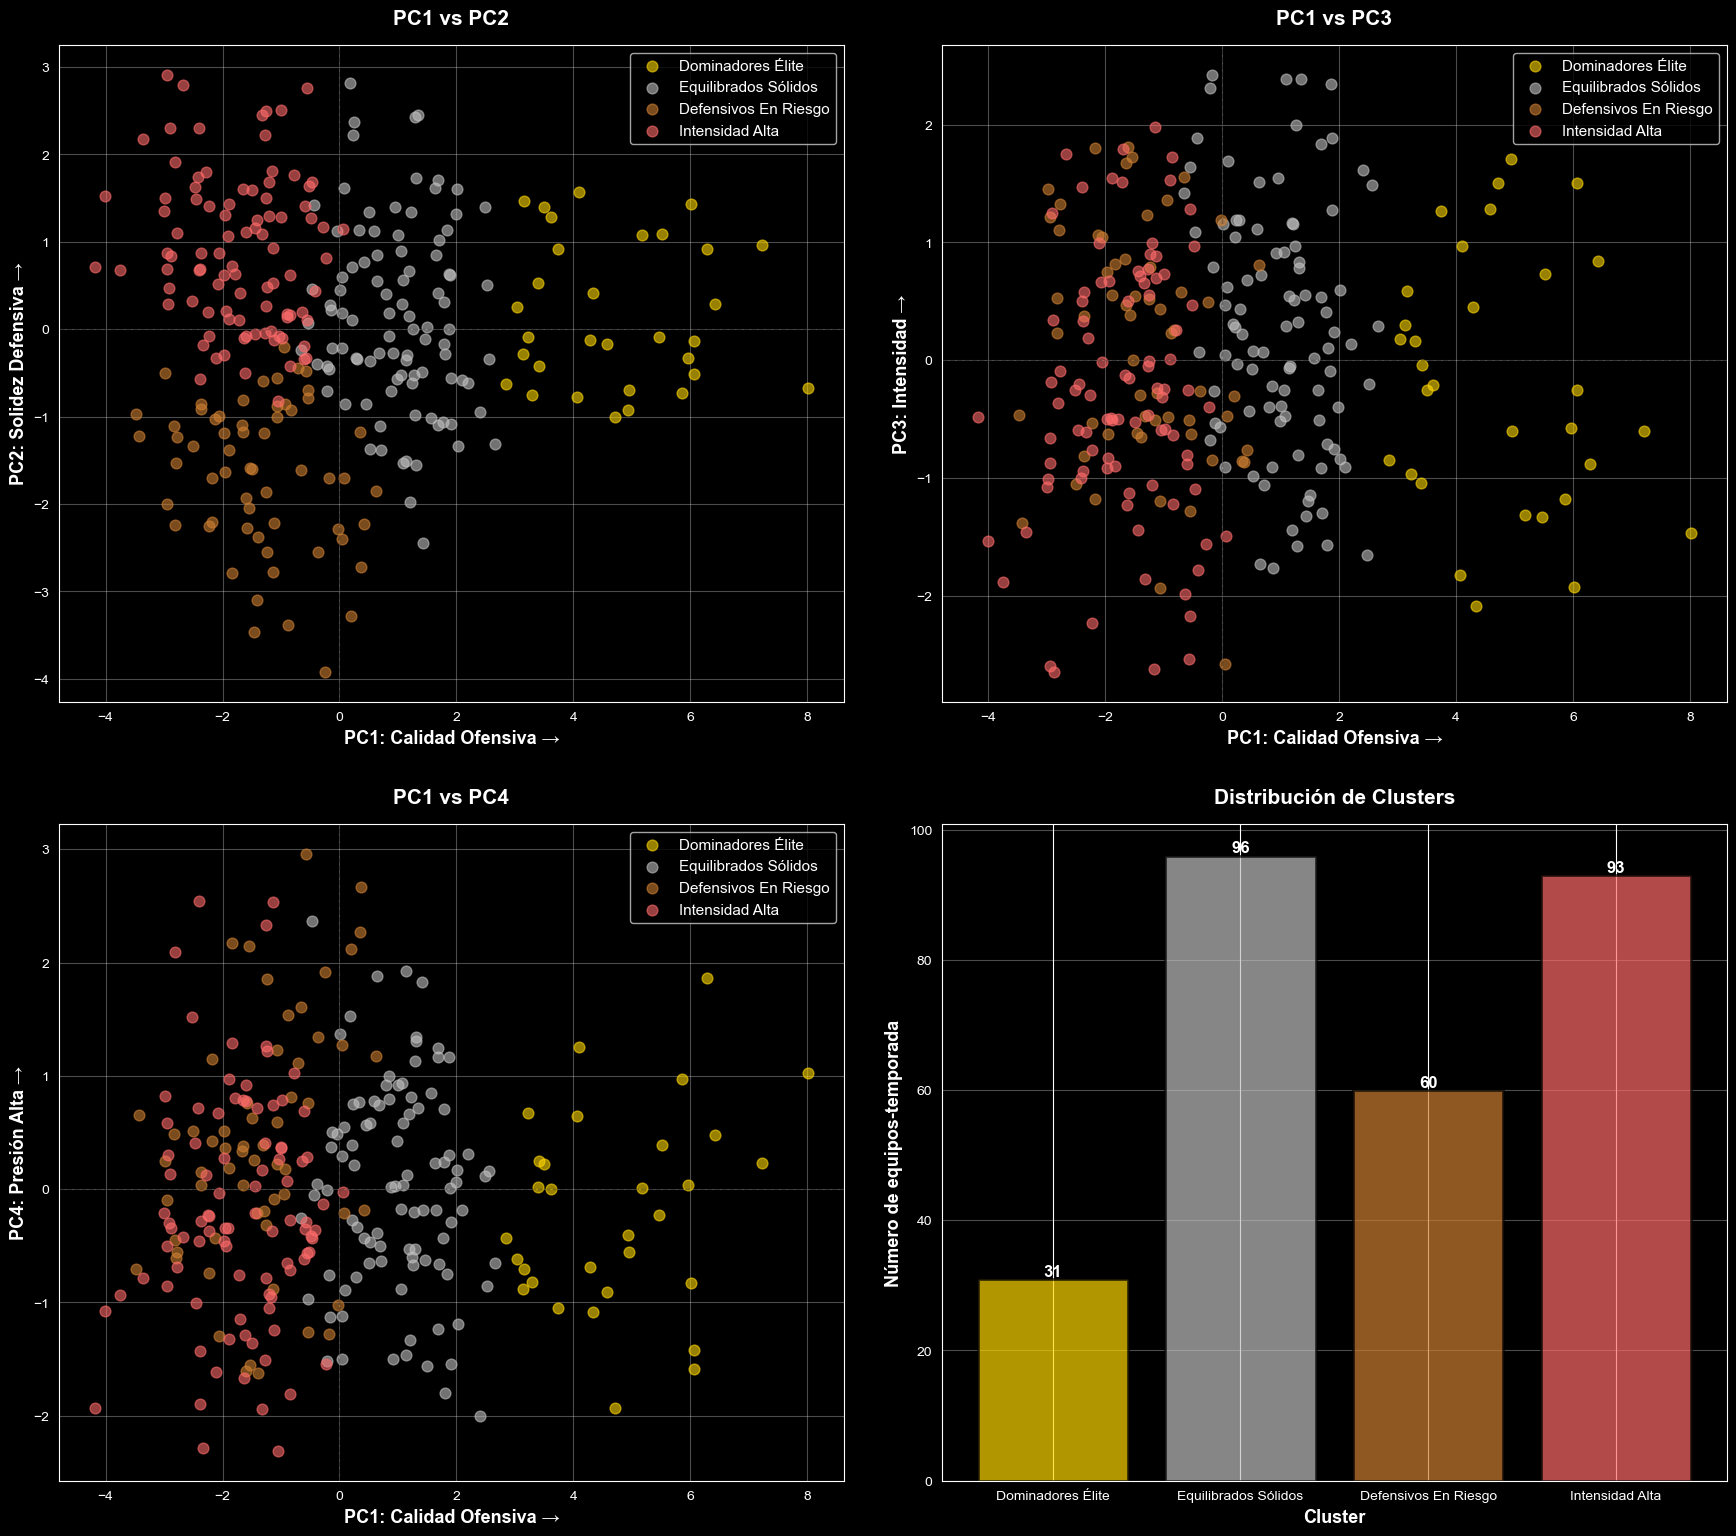

In [24]:
# Colores para cada cluster
colors_map = {
    sorted_clusters[0]: '#FFD700',  # Oro - Dominadores Élite
    sorted_clusters[1]: '#C0C0C0',  # Plata - Equilibrados Sólidos
    sorted_clusters[2]: '#CD7F32',  # Bronce - Defensivos En Riesgo
    sorted_clusters[3]: '#FF6B6B'   # Rojo - Intensidad Alta
}

# Crear figura con múltiples vistas
fig, axes = plt.subplots(2, 2, figsize=(18, 16))

# Gráfico 1: PC1 vs PC2
ax1 = axes[0, 0]
for cluster_id in sorted_clusters:
    df_cluster = df_pca[df_pca['cluster'] == cluster_id]
    label = cluster_mapping[cluster_id]
    ax1.scatter(df_cluster['PC1'], df_cluster['PC2'], 
                alpha=0.6, s=60, label=label, color=colors_map[cluster_id])

ax1.set_xlabel('PC1: Calidad Ofensiva →', fontsize=13, fontweight='bold')
ax1.set_ylabel('PC2: Solidez Defensiva →', fontsize=13, fontweight='bold')
ax1.set_title('PC1 vs PC2', fontsize=15, fontweight='bold', pad=15)
ax1.legend(fontsize=11, loc='best')
ax1.grid(True, alpha=0.3)
ax1.axhline(y=0, color='black', linestyle='--', alpha=0.3, linewidth=1)
ax1.axvline(x=0, color='black', linestyle='--', alpha=0.3, linewidth=1)

# Gráfico 2: PC1 vs PC3
ax2 = axes[0, 1]
for cluster_id in sorted_clusters:
    df_cluster = df_pca[df_pca['cluster'] == cluster_id]
    label = cluster_mapping[cluster_id]
    ax2.scatter(df_cluster['PC1'], df_cluster['PC3'],
                alpha=0.6, s=60, label=label, color=colors_map[cluster_id])

ax2.set_xlabel('PC1: Calidad Ofensiva →', fontsize=13, fontweight='bold')
ax2.set_ylabel('PC3: Intensidad →', fontsize=13, fontweight='bold')
ax2.set_title('PC1 vs PC3', fontsize=15, fontweight='bold', pad=15)
ax2.legend(fontsize=11, loc='best')
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='black', linestyle='--', alpha=0.3, linewidth=1)
ax2.axvline(x=0, color='black', linestyle='--', alpha=0.3, linewidth=1)

# Gráfico 3: PC1 vs PC4
ax3 = axes[1, 0]
for cluster_id in sorted_clusters:
    df_cluster = df_pca[df_pca['cluster'] == cluster_id]
    label = cluster_mapping[cluster_id]
    ax3.scatter(df_cluster['PC1'], df_cluster['PC4'],
                alpha=0.6, s=60, label=label, color=colors_map[cluster_id])

ax3.set_xlabel('PC1: Calidad Ofensiva →', fontsize=13, fontweight='bold')
ax3.set_ylabel('PC4: Presión Alta →', fontsize=13, fontweight='bold')
ax3.set_title('PC1 vs PC4', fontsize=15, fontweight='bold', pad=15)
ax3.legend(fontsize=11, loc='best')
ax3.grid(True, alpha=0.3)
ax3.axhline(y=0, color='black', linestyle='--', alpha=0.3, linewidth=1)
ax3.axvline(x=0, color='black', linestyle='--', alpha=0.3, linewidth=1)

# Gráfico 4: Distribución de clusters
ax4 = axes[1, 1]
cluster_counts = df_pca['cluster'].value_counts().reindex(sorted_clusters)
bars = ax4.bar(range(len(cluster_counts)), cluster_counts.values,
               color=[colors_map[c] for c in sorted_clusters], alpha=0.7, edgecolor='black', linewidth=2)
ax4.set_xlabel('Cluster', fontsize=13, fontweight='bold')
ax4.set_ylabel('Número de equipos-temporada', fontsize=13, fontweight='bold')
ax4.set_title('Distribución de Clusters', fontsize=15, fontweight='bold', pad=15)
ax4.set_xticks(range(len(cluster_counts)))
ax4.set_xticklabels([cluster_mapping[c] for c in sorted_clusters], rotation=0)
ax4.grid(True, alpha=0.3, axis='y')

# Añadir valores en las barras
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout(pad=3.0)
plt.show()

In [25]:
# Preparar colores
color_map_pca = {
    sorted_clusters[0]: '#FFD700',  # Oro - Dominadores Élite
    sorted_clusters[1]: '#C0C0C0',  # Plata - Equilibrados Sólidos
    sorted_clusters[2]: '#CD7F32',  # Bronce - Defensivos En Riesgo
    sorted_clusters[3]: '#FF6B6B'   # Rojo - Intensidad Alta
}

# Crear figura con 2 subplots
fig_pca = make_subplots(
    rows=1, cols=2,
    subplot_titles=('HOME - Local', 'AWAY - Visitante'),
    horizontal_spacing=0.12
)

# Obtener años
years = sorted(df_pca['year'].unique())

# Crear trazas por cluster, año y location
trace_index = 0
for year in years:
    for location in ['home', 'away']:
        for cluster_id in sorted_clusters:
            df_temp = df_pca[(df_pca['cluster'] == cluster_id) & 
                             (df_pca['year'] == year) &
                             (df_pca['location'] == location)].copy()
            
            label = cluster_mapping[cluster_id]
            color = color_map_pca[cluster_id]
            
            # Determinar en qué columna va (1=home, 2=away)
            col = 1 if location == 'home' else 2
            
            # Mostrar leyenda solo para home en la primera temporada
            show_legend = (location == 'home' and year == years[0])
            # show_legend = (location == 'home')
            
            fig_pca.add_trace(
                go.Scatter(
                    x=df_temp['PC1'],
                    y=df_temp['PC2'],
                    mode='markers',
                    name=label,
                    marker=dict(size=10, color=color, opacity=0.7, 
                               line=dict(width=1, color='white')),
                    text=df_temp['team'],
                    customdata=df_temp[['PC3', 'PC4']],
                    hovertemplate='<b>%{text}</b><br>' +
                                  'Temporada: ' + str(year) + '<br>' +
                                  'PC1 (Calidad): %{x:.2f}<br>' +
                                  'PC2 (Defensa): %{y:.2f}<br>' +
                                  'PC3 (Intensidad): %{customdata[0]:.2f}<br>' +
                                  'PC4 (Presión): %{customdata[1]:.2f}<br>' +
                                  '<extra></extra>',
                    # visible=(year == years[0]),
                    legendgroup=label,
                    showlegend=show_legend
                ),
                row=1, col=col
            )
            trace_index += 1

# Crear botones dropdown
buttons = []

# Botón "Todas las temporadas"
buttons.append(dict(
    label="Todas",
    method="update",
    args=[{"visible": [True] * len(fig_pca.data)},
          {"title": {"text": "<b>Clustering PCA: HOME vs AWAY - Todas las Temporadas</b>"}}]
))

# Botones por temporada
for year in years:
    visibility = []
    for y in years:
        for _ in ['home', 'away']:
            for _ in range(len(sorted_clusters)):
                visibility.append(y == year)
    
    buttons.append(
        dict(
            label=str(year),
            method="update",
            args=[{"visible": visibility},
                  {"title": {"text": f"<b>Clustering PCA: HOME vs AWAY - Temporada {year}</b>"}}]
        )
    )

# Update layout
fig_pca.update_layout(
    updatemenus=[
        dict(
            type="dropdown",
            direction="down",
            x=0.15,
            y=1.12,
            buttons=buttons,
            showactive=True,
            bgcolor='white',
            bordercolor='gray',
            font=dict(size=12)
        )
    ],
    title={
        'text': f"<b>Clustering PCA: HOME vs AWAY - Todas las Temporadas</b>",
        'x': 0.5,
        'xanchor': 'center',
        'font': {'size': 18}
    },
    hovermode='closest',
    plot_bgcolor='white',
    height=600,
    width=1400,
    legend=dict(
        title="Cluster",
        font=dict(size=11),
        bgcolor='rgba(255,255,255,0.9)',
        bordercolor='gray',
        borderwidth=1,
        x=1.01,
        y=0.5
    ),
    showlegend=True
)

# Actualizar ejes
fig_pca.update_xaxes(
    title_text="PC1: Calidad Ofensiva →",
    gridcolor='lightgray',
    showgrid=True,
    zeroline=True,
    zerolinecolor='black',
    zerolinewidth=2,
    row=1, col=1
)

fig_pca.update_xaxes(
    title_text="PC1: Calidad Ofensiva →",
    gridcolor='lightgray',
    showgrid=True,
    zeroline=True,
    zerolinecolor='black',
    zerolinewidth=2,
    row=1, col=2
)

fig_pca.update_yaxes(
    title_text="PC2: Solidez Defensiva →",
    gridcolor='lightgray',
    showgrid=True,
    zeroline=True,
    zerolinecolor='black',
    zerolinewidth=2,
    row=1, col=1
)

fig_pca.update_yaxes(
    title_text="PC2: Solidez Defensiva →",
    gridcolor='lightgray',
    showgrid=True,
    zeroline=True,
    zerolinecolor='black',
    zerolinewidth=2,
    row=1, col=2
)

fig_pca.show()

print("\n✅ Gráfico interactivo HOME vs AWAY creado")
print("📊 Usa el dropdown para filtrar por temporada")
print("🏟️ Compara visualmente el rendimiento local vs visitante")


✅ Gráfico interactivo HOME vs AWAY creado
📊 Usa el dropdown para filtrar por temporada
🏟️ Compara visualmente el rendimiento local vs visitante


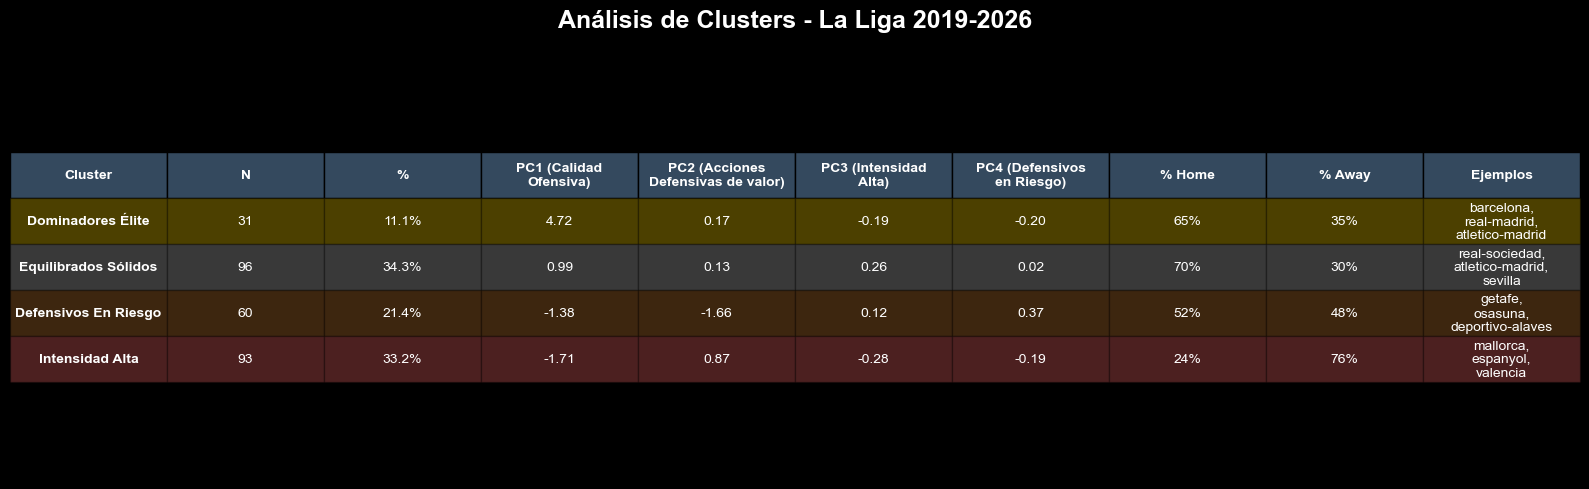

In [26]:
# Crear tabla resumen
summary_data = []
row_colors = []  # Para guardar los colores de cada fila

for cluster_id in sorted_clusters:
    df_cluster = df_pca[df_pca['cluster'] == cluster_id]
    summary_data.append({
        'Cluster': cluster_mapping[cluster_id],
        'N': len(df_cluster),
        '%': f"{len(df_cluster)/len(df_pca)*100:.1f}%",
        'PC1 (Calidad\nOfensiva)': f"{df_cluster['PC1'].mean():.2f}",
        'PC2 (Acciones\nDefensivas de valor)': f"{df_cluster['PC2'].mean():.2f}",
        'PC3 (Intensidad\nAlta)': f"{df_cluster['PC3'].mean():.2f}",
        'PC4 (Defensivos\nen Riesgo)': f"{df_cluster['PC4'].mean():.2f}",
        '% Home': f"{(df_cluster['location']=='home').sum()/len(df_cluster)*100:.0f}%",
        '% Away': f"{(df_cluster['location']=='away').sum()/len(df_cluster)*100:.0f}%",
        'Ejemplos': ',\n'.join(df_cluster['team'].value_counts().head(3).index)
    })
    
    # Guardar el color correspondiente
    row_colors.append(color_map_pca[cluster_id])

summary_df = pd.DataFrame(summary_data)

# Visualizar como tabla
fig, ax = plt.subplots(figsize=(16, 5))
ax.axis('tight')
ax.axis('off')

# Crear tabla
table = ax.table(cellText=summary_df.values,
                colLabels=summary_df.columns,
                cellLoc='center',
                loc='center')

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2.5)

# Colorear el encabezado
for i in range(len(summary_df.columns)):
    table[(0, i)].set_facecolor('#34495E')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Colorear cada fila según su cluster
for i in range(len(summary_data)):
    # i+1 porque 0 es el encabezado
    for j in range(len(summary_df.columns)):
        table[(i+1, j)].set_facecolor(row_colors[i])
        table[(i+1, j)].set_alpha(0.3)  # Transparencia para que sea legible
        
        # Primera columna (nombre del cluster) en negrita
        if j == 0:
            table[(i+1, j)].set_text_props(weight='bold')

plt.title('Análisis de Clusters - La Liga 2019-2026', 
          fontsize=18, fontweight='bold', pad=20)
plt.tight_layout()
# plt.savefig('tabla_resumen_clusters.png', dpi=300, bbox_inches='tight',
#             facecolor='white')
plt.show()
# print("✅ Tabla guardada como 'tabla_resumen_clusters.png'")